# Neural network module

Here we construct the neural network module. The `Module` class defines an abstract class that maintains a list of the parameters used in forward pass implemented in `__call__`. The decorator `@final` is to prevent any inheriting class from overriding the methods as doing so would result in a warning (or an error with a type checker).

In [1]:
from chapter import *

In [2]:
%%save
from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self):
        self._parameters = []

    @final
    def parameters(self) -> list:
        return self._parameters

    @abstractmethod
    def __call__(self, x: list):
        pass

    @final
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self):
        self._parameters = []

    @final
    def parameters(self) -> list:
        return self._parameters

    @abstractmethod
    def __call__(self, x: list):
        pass

    @final
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

The `_parameters` attribute is defined so that the parameter list is not constructed at each call of the `parameters()` method. Implementing layers from neurons:

In [3]:
%%save

class Neuron(Module):
    def __init__(self, n_in, activation=None):
        self.n_in = n_in
        self.act = activation

        self.w = [Node(random.random()) for _ in range(n_in)]
        self.b = Node(0.0)
        self._parameters = self.w + [self.b]

    def __call__(self, x: list):
        assert len(x) == self.n_in
        out = sum((x[j] * self.w[j] for j in range(self.n_in)), start=self.b)
        if self.act is not None:
            if self.act == "tanh":
                out = out.tanh()
            elif self.act == "relu":
                out = out.relu()
            else:
                raise NotImplementedError("Activation not supported.")
        return out

    def __repr__(self):
        return f"{self.act if self.act is not None else 'linear'}({len(self.w)})"


class Layer(Module):
    def __init__(self, n_in, n_out, *args):
        self.neurons = [Neuron(n_in, *args) for _ in range(n_out)]
        self._parameters = [p for n in self.neurons for p in n.parameters()]

    def __call__(self, x: list):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def __repr__(self):
        return f"Layer[{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):
    def __init__(self, n_in, n_outs, activation=None):
        sizes = [n_in] + n_outs
        self.layers = []
        for i in range(len(n_outs)):
            act = activation if i < len(n_outs) - 1 else None
            layer = Layer(sizes[i], sizes[i + 1], act)
            self.layers.append(layer)

        self._parameters = [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP[{', '.join(str(layer) for layer in self.layers)}]"

class Neuron(Module):
    def __init__(self, n_in, activation=None):
        self.n_in = n_in
        self.act = activation

        self.w = [Node(random.random()) for _ in range(n_in)]
        self.b = Node(0.0)
        self._parameters = self.w + [self.b]

    def __call__(self, x: list):
        assert len(x) == self.n_in
        out = sum((x[j] * self.w[j] for j in range(self.n_in)), start=self.b)
        if self.act is not None:
            if self.act == "tanh":
                out = out.tanh()
            elif self.act == "relu":
                out = out.relu()
            else:
                raise NotImplementedError("Activation not supported.")
        return out

    def __repr__(self):
        return f"{self.act if self.act is not None else 'linear'}({len(self.w)})"


class Layer(Module):
    def __init__(self, n_in, n_out, *args):
        self.neurons = [Neuron(n_in, *args) for _ in range(n_out)]
        self._parameters = [p for n in self.neurons for p in n.parameters()]

    def __call__(self, x: list):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def __repr__(self):
        return f"Layer[{', '.join(str(n) for n in self.neurons)}]"


class MLP(Module):
    def __init__(self, n_in, n_outs, activation=None):
        sizes = [n_in] + n_outs
        self.layers = []
        for i in range(len(n_outs)):
            act = activation if i < len(n_outs) - 1 else None
            layer = Layer(sizes[i], sizes[i + 1], act)
            self.layers.append(layer)

        self._parameters = [p for layer in self.layers for p in layer.parameters()]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"MLP[{', '.join(str(layer) for layer in self.layers)}]"

Testing model init and model call. Note that the final node has no activation:

In [4]:
model = MLP(n_in=1, n_outs=[2, 4, 1], activation="relu")
x = Node(1.0)
pred = model([x])
pred.backward()

print(model)
print(pred.data)

MLP[Layer[relu(1), relu(1)], Layer[relu(2), relu(2), relu(2), relu(2)], Layer[linear(4)]]
0.3551933990615996


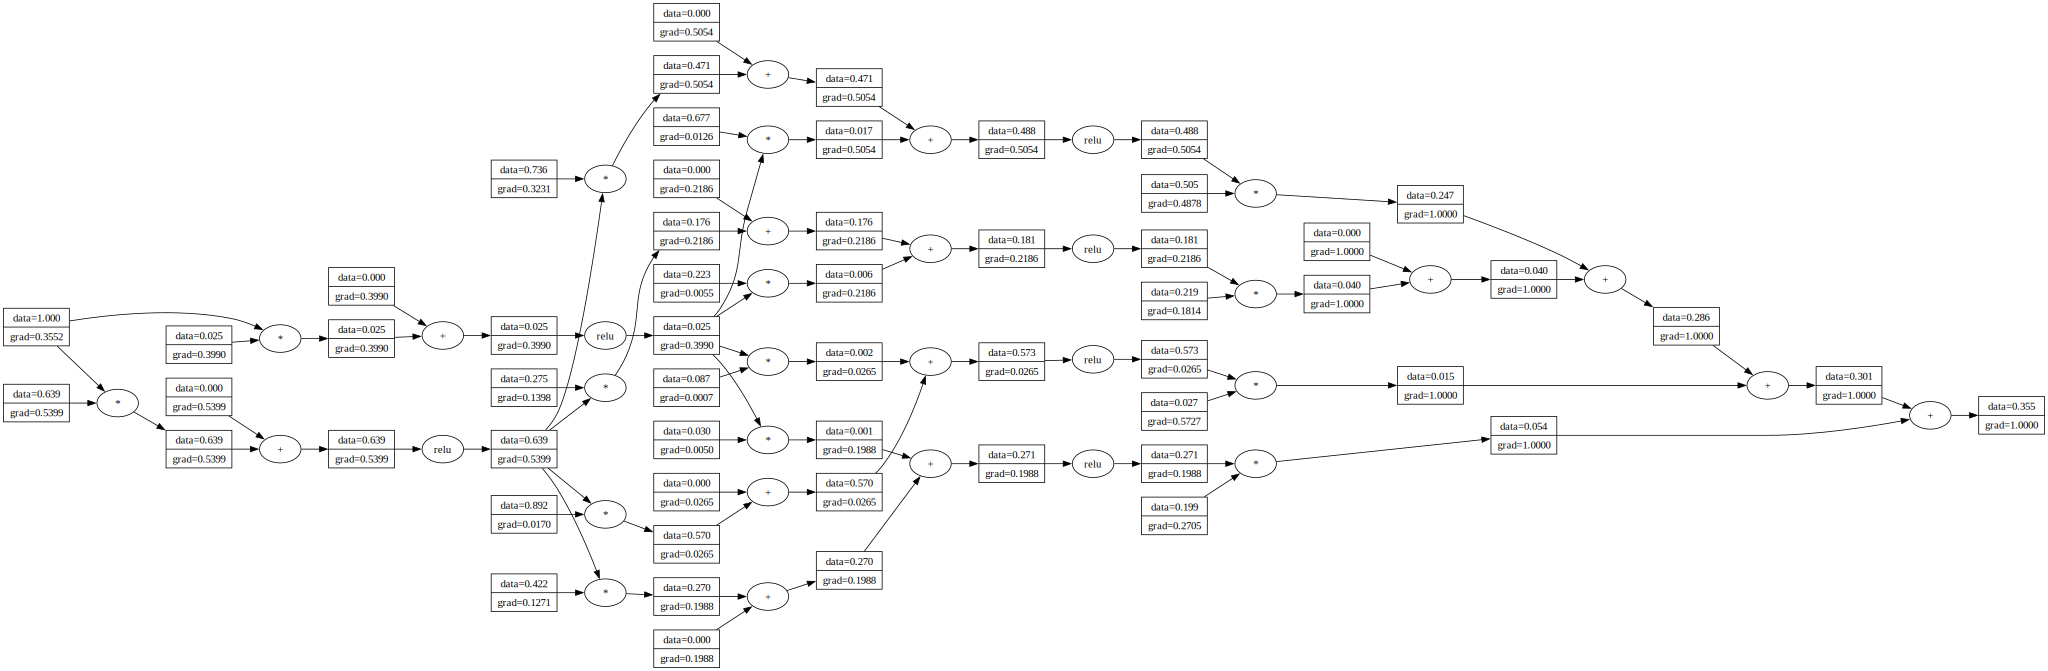

In [5]:
draw_graph(pred)